In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml

In [61]:
device = "cuda"

In [62]:
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
You should 

In [105]:
prompt_config = PromptConfig(dataset_name)
dataset = PromptDataset(prompt_config, split="train")

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 604.98it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


In [109]:
def get_ccs_pair(prompt):
    return (
        f"{prompt.question} {prompt.answers[0]}",
        f"{prompt.question} {prompt.answers[1]}"
    )

In [111]:
dataset[0][0]

Prompt(prefix='', template=<elk.promptsource.templates.Template object at 0x7fe75728da80>, example={'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.', 'label': 0}, label=1, label_column='label')

In [114]:
def dsget(dataset, i):
    return "".join(list(dataset.prompter.templates.values())[0].apply(
        dataset.active_split[i]
    ))

In [115]:
dsget(dataset, 0)

'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nWorld politics'

In [4]:
RPATH = "/fsx/home-rudolf/elk-reporters"

def load_config(name, rpath=RPATH):
    """Loads yaml config from RPATH/[name]/cfg.yaml"""
    with open(os.path.join(rpath, name, "cfg.yaml"), "r") as f:
        return yaml.safe_load(f)

In [7]:
load_config("friendly-montalcini")

{'data': {'layers': [],
  'model': 'microsoft/deberta-v2-xxlarge-mnli',
  'prompts': {'balance': False,
   'data_dir': None,
   'dataset': 'ag_news',
   'label_column': None,
   'max_examples': [750, 250],
   'num_classes': None,
   'num_shots': 0,
   'num_variants': 1,
   'seed': 42},
  'token_loc': 'last'},
 'debug': False,
 'max_gpus': -1,
 'net': {'activation': 'gelu',
  'bias': True,
  'hidden_size': None,
  'init': 'default',
  'loss': ['1.0*ccs'],
  'loss_dict': {'ccs': 1.0},
  'lr': 0.01,
  'net_name': 'ccs',
  'num_epochs': 1000,
  'num_layers': 1,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'pre_ln': False,
  'seed': 999,
  'supervised_weight': 0.0,
  'weight_decay': 0.01},
 'normalization': 'meanonly',
 'optim': {'lr': 0.01,
  'num_epochs': 1000,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'weight_decay': 0.01},
 'skip_baseline': False}

In [63]:
def get_relevant_runs(reqs, rpath=RPATH):
    """Requirements is a dictionary of the form:
    property specification, e.g. "data.prompts.dataset"
    --->
    required value"""
    valid_reporters = []
    for name in os.listdir(rpath):
        cfg = load_config(name, rpath)
        add = True
        for prop, reqval in reqs.items():
            prop_parts = prop.split(".")
            temp = cfg
            for next_level in prop_parts:
                if next_level in temp.keys():
                    temp = temp[next_level]
                else:
                    add = False
                    break
            if temp != reqval:
                add = False
                break
        if add:
            valid_reporters.append(name)
    return valid_reporters

def get_eval(run_name):
    return pd.read_csv(os.path.join(RPATH, run_name, "eval.csv"))

def graph_eval(run_name):
    eval = get_eval(run_name)
    fig, ax = plt.subplots()
    ax.scatter(eval["layer"], eval["acc"], label="acc")
    ax.scatter(eval["layer"], eval["lr_acc"], label="LR acc")
    ax.legend()
    ax.set_title(f"{load_config(run_name)['data']['model']} on {load_config(run_name)['data']['prompts']['dataset']}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    fig.show()

def num_from_str(s):
    """Strip all non-numeric characters from s and interpret as a number"""
    num_str = ''
    for char in s:
        if char.isdigit():
            num_str += char
    if num_str == '':
        return None
    else:
        return int(num_str)

def get_reporters(run_name):
    r_dict = {
        layer_number : t.load(os.path.join(RPATH, run_name, "reporters", layer_name)).to(device)
        for (layer_number, layer_name) in [
            (num_from_str(layer_name), layer_name)
            for layer_name in os.listdir(os.path.join(RPATH, run_name, "reporters"))
            ]
        }
    return [r_dict[i] for i in range(len(r_dict))]

In [64]:
runs = get_relevant_runs(
    {
        "data.prompts.dataset": dataset_name,
        "net.net_name": "ccs",
        "data.model": model_name
    }
)

In [65]:
runs

['objective-ritchie', 'competent-curie', 'vibrant-fermi', 'serene-jang']

In [66]:
run = runs[-1]

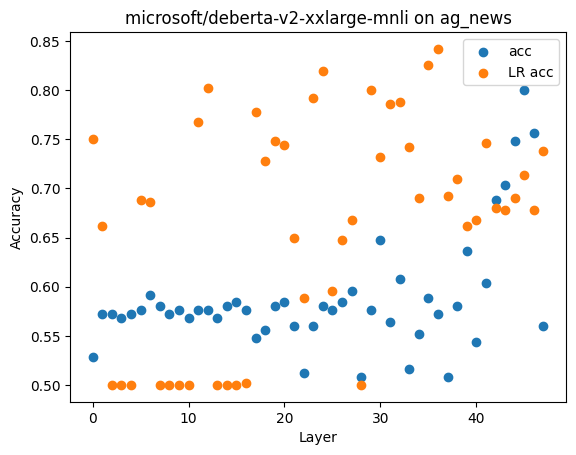

In [67]:
graph_eval(run)

In [68]:
reporters = get_reporters(run)

In [69]:
reporters[0]

CcsReporter(
  (probe): Sequential(
    (0): Linear(in_features=1536, out_features=1, bias=True)
  )
)

In [96]:
def reporter_outputs(reporters, sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
    outo = model(inputs["input_ids"], output_hidden_states=True)
    # the +1 in i+1 is because the first hidden state is the input embedding
    return t.stack([r(outo[1][i+1])[0] for i, r in enumerate(reporters)], dim=0)

def plot_2d_tensor_as_heatmap(t2d):
    fig, ax = plt.subplots()
    heatmap = ax.imshow(t2d.cpu().detach().numpy(), cmap="hot", interpolation="nearest")
    ax.set_xlabel("Token")
    ax.set_ylabel("Reporter (=layer)")
    plt.colorbar(heatmap)

def best_layer_output(run_name, sentence):
    layer_eval = get_eval(run_name)
    # find the row in the pandas dataframe layer_eval with the highest accuracy:
    best_layer = layer_eval["layer"][layer_eval["acc"].idxmax()]
    reporter = get_reporters(run_name)[best_layer]
    return reporter_outputs([reporter], sentence)[0]

In [101]:
best_layer_output(run, "Is 1+1=2? Yes")

tensor([-0.4311, -0.3070, -0.6290, -0.9326, -0.9251, -0.5465, -1.0682, -0.6535,
        -0.3852], device='cuda:0', grad_fn=<SelectBackward0>)

In [79]:
r_outs = reporter_outputs(reporters, "Is 1 + 1 = 2? No")

In [80]:
r_outs.shape

torch.Size([48, 11])

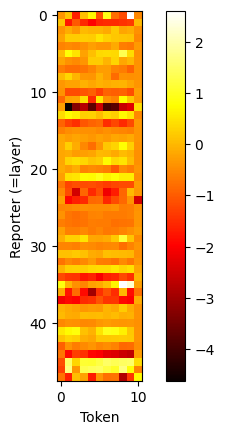

In [81]:
plot_2d_tensor_as_heatmap(r_outs)